## Getting the Depth from an Monocular camera image 

### Step 0 : Create an framework for getting the bbox 

In [ ]:
#!python3 -m pip install yolov4==2.0.2

In [86]:
from yolov4.tf import YOLOv4
import tensorflow as tf
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

(576, 1024, 3)


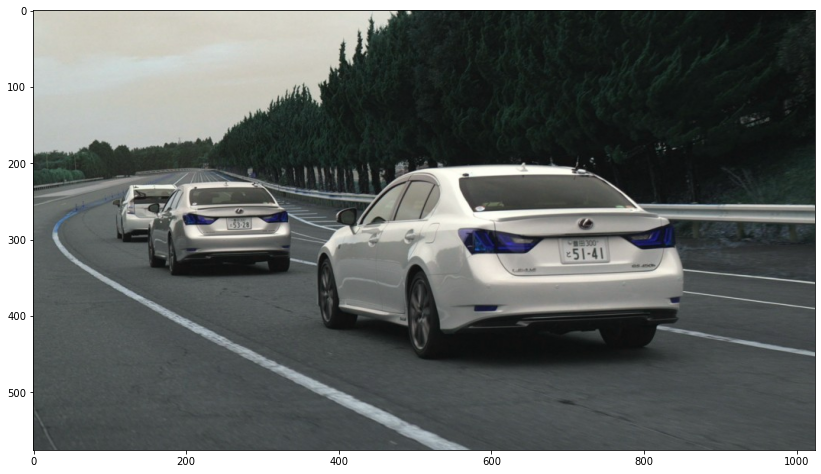

In [148]:
# Load the image 
img_left = cv2.imread("images/2.jpg")
plt.figure(figsize = (14, 10))
plt.imshow(img_left)
print(img_left.shape)

### Step 1 : Getting the bbox 

time: 1912.54 ms
time: 1923.12 ms
time: 1933.61 ms


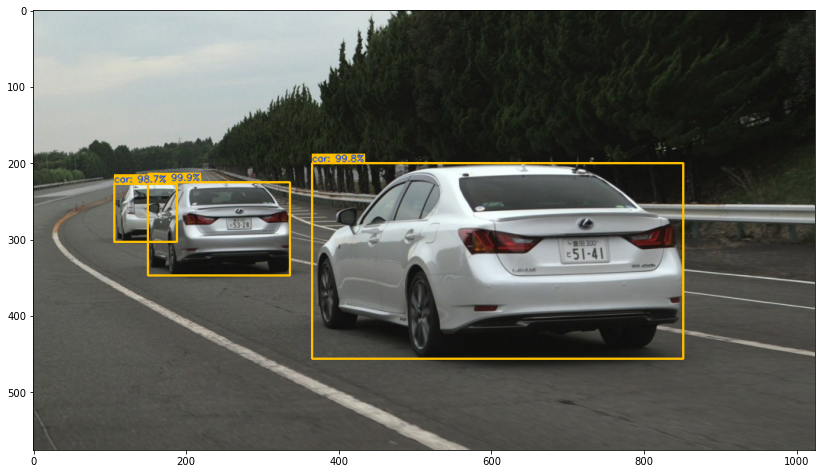

In [149]:
yolo = YOLOv4()
yolo.classes = "Yolov4/coco.names"
yolo.make_model()
yolo.load_weights("Yolov4/yolov4.weights", weights_type="yolo")

def run_obstacle_detection(img):
    start_time=time.time()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = yolo.resize_image(img)
    # 0 ~ 255 to 0.0 ~ 1.0
    resized_image = resized_image / 255.
    #input_data == Dim(1, input_size, input_size, channels)
    input_data = resized_image[np.newaxis, ...].astype(np.float32)

    candidates = yolo.model.predict(input_data)

    _candidates = []
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(tf.reshape(candidate, shape=(1, grid_size * grid_size * 3, -1)))
        # candidates == Dim(batch, candidates, (bbox))
        candidates = np.concatenate(_candidates, axis=1)

        # pred_bboxes == Dim(candidates, (x, y, w, h, class_id, prob))
        pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0], iou_threshold=0.35, score_threshold=0.40)
        pred_bboxes = pred_bboxes[~(pred_bboxes==0).all(1)] #https://stackoverflow.com/questions/35673095/python-how-to-eliminate-all-the-zero-rows-from-a-matrix-in-numpy?lq=1
        pred_bboxes = yolo.fit_pred_bboxes_to_original(pred_bboxes, img.shape)
        exec_time = time.time() - start_time
        print("time: {:.2f} ms".format(exec_time * 1000))
        result = yolo.draw_bboxes(img, pred_bboxes)
    return result, pred_bboxes

result, pred_bboxes = run_obstacle_detection(img_left)
plt.figure(figsize = (14, 10))
plt.imshow(result)
plt.show() 

## Step 2 : Get the Depth map 

In [150]:
# load model
interpreter = tf.lite.Interpreter(model_path="lite-model_midas_v2_1_small_1_lite_1.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

In [151]:
def get_depth_map(img_path):
    
    # read the input
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    
    #image pre-processing
    img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
    #img_resized = tf.transpose(img_resized, [2, 0, 1])
    img_input = img_resized.numpy()
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img_input = (img_input - mean) / std
    reshape_img = img_input.reshape(1,256,256,3)
    tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)
    
    # inference
    interpreter.set_tensor(input_details[0]['index'], tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    output = output.reshape(256, 256)
    
    # output file
    prediction = cv2.resize(output, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    depth_min = prediction.min()
    depth_max = prediction.max()
    img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")
    
    cv2.imwrite("output.png", img_out)
    
    return img_out
 

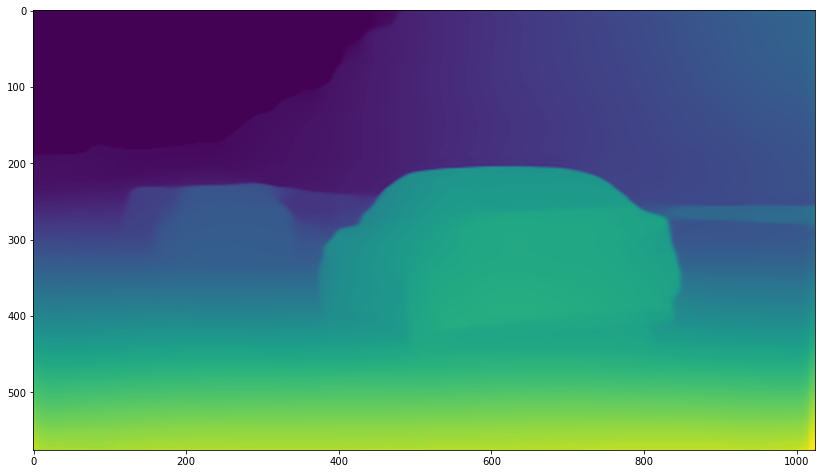

In [152]:
# get the depth map 
depth_map = get_depth_map("images/2.jpg")
plt.figure(figsize = (14, 10))
plt.imshow(depth_map)

1

## Combine Depth Map and bbox info for getting the distance in meters 

In [153]:
# Anaysis of the bbox output
h, w, _ = img_left.shape
#h, w, _  = 256,256,3
testing_box = pred_bboxes[0]
print("original box", testing_box)
print("center_x:",testing_box[0]*w)
print("center_y",testing_box[1]*h)
print("width:", testing_box[2]*w)
print("height:",testing_box[3]*h)

original box [0.23794864 0.49689526 0.18214726 0.2119492  2.         0.99869275]
center_x: 243.65940856933594
center_y 286.211669921875
width: 186.518798828125
height: 122.0827407836914


In [154]:
def find_distances(depth_map, pred_bboxes, img, method="center"):
    depth_list = []
    h, w, _ = img.shape
    print("shape :",img.shape)
    #h, w, _  = 256,256,3
    for box in pred_bboxes:
        x1 = int(box[0]*w - box[2]*w*0.5) # center_x - width /2
        y1 = int(box[1]*h-box[3]*h*0.5) # center_y - height /2
        x2 = int(box[0]*w + box[2]*w*0.5) # center_x + width/2
        y2 = int(box[1]*h+box[3]*h*0.5) # center_y + height/2
        print(np.array([x1, y1, x2, y2]))
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if method=="closest":
            depth_list.append(obstacle_depth.min()) # take the closest point in the box
        elif method=="average":
            depth_list.append(np.mean(obstacle_depth)) # take the average
        elif method=="median":
            depth_list.append(np.median(obstacle_depth)) # take the median
        else:
            depth_list.append(depth_map[int(box[1]*h)][int(box[0]*w)]) # take the center
            
            
        #break
    return depth_list

depth_list = find_distances(depth_map, pred_bboxes, img_left, method="median")
print(depth_list)


shape : (576, 1024, 3)
[150 225 336 347]
[365 199 852 456]
[105 227 188 304]
[72.0, 145.0, 49.0]


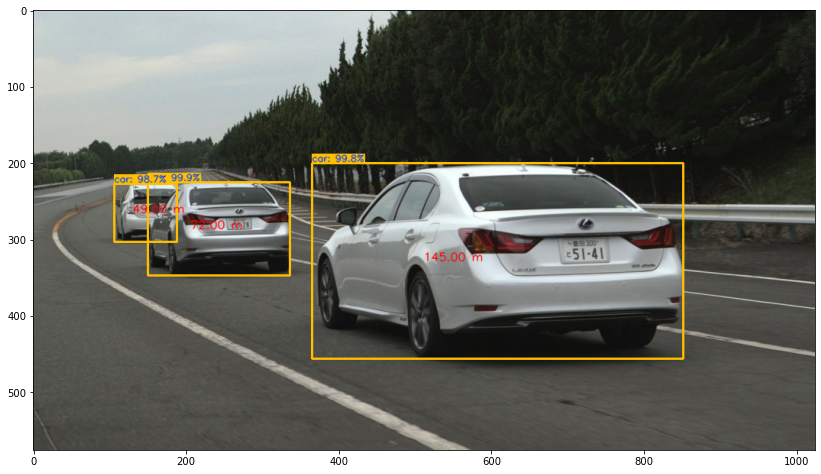

In [155]:
def add_depth(depth_list, result, pred_bboxes):
    h, w, _ = result.shape
    res = result.copy()
    for i, distance in enumerate(depth_list):
        cv2.putText(res, '{0:.2f} m'.format(distance), (int(pred_bboxes[i][0]*w - pred_bboxes[i][2]*w*0.2),int(pred_bboxes[i][1]*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)    
    return res

res = add_depth(depth_list, result, pred_bboxes)

plt.figure(figsize = (14,10))
plt.imshow(res)